In [ ]:
!git clone https://github.com/pytorch/captum.git
%cd captum
!pip install -e 

In [ ]:
!pip install adversarial-robustness-toolbox

In [2]:
import numpy as np
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchvision import datasets
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [111]:
# Import Captum
from captum.attr import Saliency
from captum.attr import visualization as vis
from captum.attr import (
	  GuidedBackprop,
	  Occlusion,
	  Saliency,
	  IntegratedGradients,
		GradientShap,
		Deconvolution,
		DeepLift,
		LRP,
		Lime,
    DeepLiftShap
	)

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torch import Tensor

In [ ]:
# Download and prepare training and test data.
	
training_data = datasets.FashionMNIST(
	  root="data",
	  train=True,	
    download=True,	
    transform = transforms.Compose([transforms.ToTensor(),])	
)
	
test_data = datasets.FashionMNIST(	
    root="data",	
    train=False,	
    download=True,	
    transform=transforms.Compose([transforms.ToTensor(),])	
)
	
train_data_loader = DataLoader(training_data, batch_size=128)
	
test_data_loader = DataLoader(test_data, batch_size=128)

In [8]:
#simple CNN Model for Fashion MNIST (with 2 convolutional layers)
class FashionNetwork(nn.Module):
	
    def __init__(self):
        super(FashionNetwork, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1)
        self.drop = nn.Dropout(0.25)
        self.lin1 = nn.Linear(in_features=16*24*24,out_features=10)   
	
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.conv_2(x)
        x = F.relu(x)
        x = self.drop(x)

        x = x.reshape(-1,16*24*24)
        x = self.lin1(x)


        return x
	

In [10]:
#train Fashion MNIST model
def train_loop(data_loader, model, loss_function, optimizer):
  for batch, (data, labels) in enumerate(data_loader):
    # Feed data through network and compute loss.
    prediction = model(data)
    loss = loss_function(prediction, labels)

    # Zero gradients.
    optimizer.zero_grad()
 
    # Perform backpropagation and accumulate gradients.
    loss.backward()

    # Update network parameters.
    optimizer.step()
	
 
	

In [11]:
def test_loop(data_loader, model, loss_function):
  n_samples = len(data_loader.dataset)
  n_batches = len(data_loader)
  
  loss, n_correct = 0, 0
		
  with torch.no_grad():
    for data, labels in data_loader:
      # Feed data through network and accumulate loss.
      prediction = model(data)

      this_loss = loss_function(prediction, labels).item()

      loss += this_loss
      
      n_correct += ((prediction.argmax(1) == labels).type(torch.float).sum().item())
	
 
	
  print(
      f"Test Accuracy: {n_correct / n_samples:.2%}, "
      f"Test Loss: {loss / n_batches:.4}"
  )

    
	
 

In [12]:
# Initialize network, loss function, and optimizer.
simple_cnn_model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=learning_rate)

In [ ]:
# Train the network.
n_epochs = 5
	
for t in range(n_epochs):
  print(f"Epoch {t + 1:02}", end=" ", flush=True) 
  train_loop(train_data_loader, simple_cnn_model, loss_fn, optimizer)
  test_loop(test_data_loader, simple_cnn_model, loss_fn)



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [140]:
#model_save_name = 'improved_model_longer_training.pt'
model_save_name = 'simple_cnn_model.pt'
#model_save_name = 'pretrained_model.pt'
path = F"/content/drive/My Drive/{model_save_name}" 


In [141]:
simple_cnn_model = FashionNetwork()
simple_cnn_model.load_state_dict(torch.load(path))
simple_cnn_model.eval()

ImprovedFashionNetwork(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (lin1): Linear(in_features=192, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=40, bias=True)
  (lin3): Linear(in_features=40, out_features=10, bias=True)
)

In [17]:
# Decode prediction.
label_names = ['T-shirtTop', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']


In [142]:
model = simple_cnn_model
d = iter(test_data_loader)
images, labels = d.next()

In [105]:
#sandals: 8 11
#bag 18 30
im = 8

tensor = images[im]

# Feed input through network.
prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

5
5


In [109]:
#get best, second best and worst label prediction
predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
sorted_values, sorted_idx = torch.topk(values, 10)


In [89]:
sorted_values.cpu().squeeze()

tensor([1.0000e+00, 9.6217e-10, 1.4482e-10, 3.2400e-11, 2.9683e-11, 2.4708e-12,
        9.6226e-13, 6.6654e-13, 1.7521e-13, 1.5223e-13],
       grad_fn=<SqueezeBackward0>)

In [90]:
best_worst_class_values = [sorted_values[i] for i in [0,1,-1]]
best_worst_class_idx = [sorted_idx[i] for i in [0,1,-1]]

In [91]:
best_worst_class_idx

[tensor(8), tensor(0), tensor(9)]

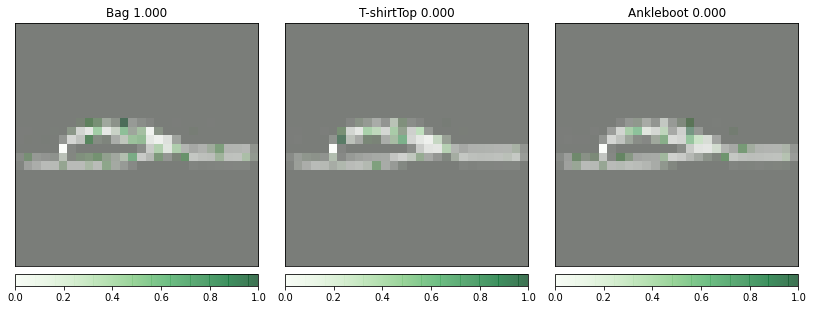

In [108]:
#LRP explanation for best, second best and worst label prediction
lrp= LRP(model)

figure, axes = plt.subplots(1, 3, figsize=(3 * 3.8, 2 * 3.8))
	
for axis, i, v in zip(axes.flatten(),best_worst_class_idx,best_worst_class_values):
  attribution = (lrp.attribute(tensor, target=int(i)).detach().numpy().squeeze())
  #vis.visualize_image_attr(None, org_image, method="original_image")
 
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           #method="heat_map", 
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True, 
                           use_pyplot=False)
	
  axis.set_title(label_names[i.item()] + f" {v:0.3f}")
	
plt.tight_layout()
	
figure.savefig("lrp.svg", bbox_inches="tight")

In [ ]:
#PART 2

8
8


/content/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/content/captum/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


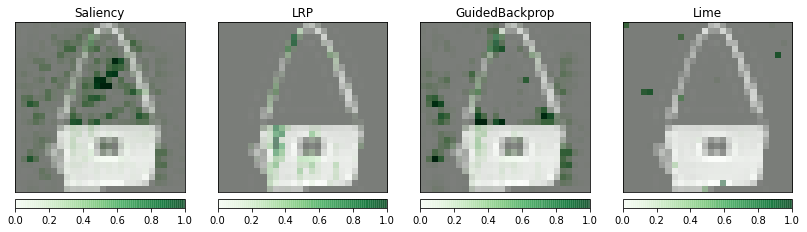

In [244]:
im = 31
tensor = images[im]

prediction = model(tensor).argmax().item()
print(prediction)
print(labels[im].item())


org_image=np.transpose(test_data[im][0].numpy(), (1,2,0))

methods = [
	  (Saliency(model), {}),
    (LRP(model), {}),
    #(DeepLift(model), {}),
    #(DeepLiftShap(model), {}),
	  (GuidedBackprop(model), {}),
    #(IntegratedGradients(model), {}),
    (Lime(model), {}),
    #(GradientShap(model), {"baselines"=torch.zeros_like(X[:1])}),
	  #(Occlusion(model),{"sliding_window_shapes": (2,2), "strides": (2,2),}),
	]

figure, axes = plt.subplots(1, 4, figsize=(3 * 3.8, 2 * 3.8))
for axis, (method, params) in zip(axes.flatten(), methods):
  attribution = (method.attribute(tensor, target=prediction, 
                                  **params).cpu().detach().numpy().squeeze())
	
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True,
                           use_pyplot=False,)

  
  axis.set_title(type(method).__name__)
	
 
plt.tight_layout()
	
figure.savefig("before_attack.png", bbox_inches="tight")

In [245]:
#untargeted attack
classifier = PyTorchClassifier(
        model=model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(model.parameters(), lr=1e-3),
        input_shape=(1, 26, 26),
        nb_classes=10
    )

attack = FastGradientMethod(estimator=classifier, eps=0.2)
imgs_adv = attack.generate(x=Tensor.cpu(tensor).numpy())

In [130]:
imgs_adv.shape

(1, 28, 28)

/content/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/content/captum/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


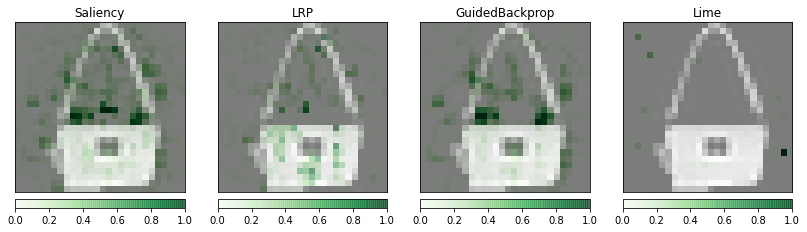

In [246]:
#explain again
tensor = torch.from_numpy(imgs_adv)


figure, axes = plt.subplots(1, 4, figsize=(3 * 3.8, 2 * 3.8))
for axis, (method, params) in zip(axes.flatten(), methods):
  #figure, axes = plt.subplots(2, 2, figsize=(2 * 3.8, 2 * 3.8))
  attribution = (method.attribute(tensor, target=prediction, 
                                  **params).cpu().detach().numpy().squeeze())
	
  vis.visualize_image_attr(attribution.reshape(28,28,1),original_image=org_image,
                           method="blended_heat_map",sign="positive",plt_fig_axis=(figure, axis),
                           show_colorbar=True,
                           use_pyplot=False,)

  
  axis.set_title(type(method).__name__)
	
 
plt.tight_layout()
	
figure.savefig("after_attack.png", bbox_inches="tight")